This script generates all the simulated images I was using to test the extraction of the plate scale and spectrum from the sidelobes. It's the partner notebook to plate_scale_spectrum_fit.ipynb

This simulates a single star Toliman PSF with sidelobes using poppy and the functions in poppy_model.py

In [1]:
from importlib import reload
import poppy
import poppy_model
reload(poppy_model)
import numpy as np
import matplotlib.pyplot as plt
import pysynphot as S
from matplotlib.colors import LogNorm
import time

from scipy.interpolate import interp1d
import astropy.units as u
from multiprocessing import Pool

from astropy.io import fits
from astropy import constants as const
from astropy import units

In [2]:
# Some setup params
npix = 2000
# pscale = 0.375
pscale=0.156

Actual FWHM: 100.3 nm


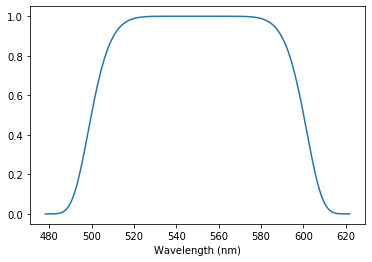

In [3]:
# Filter bandpass
# Default is 550e-9, 105e-9
central_wav = 550e-9 # m
width = 115e-9 # m
n_wavs = 200
wavs = np.linspace(central_wav-width/1.6,central_wav+width/1.6,num=n_wavs) # Go a bit past the edges

filter_n,filter_sigma = 8,105e-9 # Slightly smooth top-hat
# filter_n,filter_sima = 300,105e-9 # Square
# filter_n,filter_sigma = 2,50e-9 # Gaussian

bandpass = poppy_model.supergaussian(wavs,central_wav,sigma=filter_sigma,n=filter_n)

# Check the FWHM
left_interp = interp1d(bandpass[0:n_wavs//2]/np.max(bandpass),wavs[0:n_wavs//2])
right_interp = interp1d(bandpass[n_wavs//2:]/np.max(bandpass),wavs[n_wavs//2:])
print('Actual FWHM: {0:.1F} nm'.format((right_interp(0.5)-left_interp(0.5))*1e9))
plt.plot(wavs*1e9,bandpass)
plt.xlabel('Wavelength (nm)');

Text(0.5, 0, 'Wavelength (nm)')

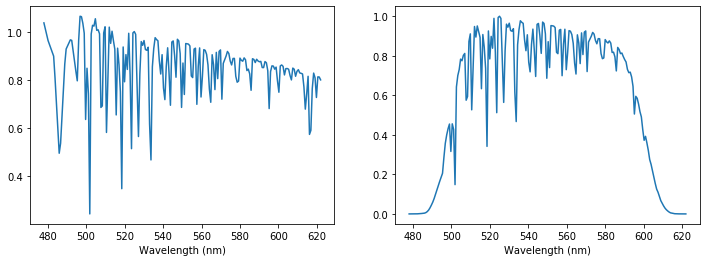

In [4]:
# Stellar spectrum

# alpha cen A: Teff = 5790, Z = 0.20, log g = 4.30
primary_teff = 5790
primary_z = 0.2
primary_logg = 4.3
acenA = S.Icat('phoenix',primary_teff,primary_z,primary_logg)

specA = acenA.sample(wavs*1e10) # This needs angstroms as input

# Normalize so combined spectrum maxes at 1
specA /= np.max(specA*bandpass)

fig,(ax1,ax2) = plt.subplots(1,2,clear=True,figsize=(12,4))
ax1.plot(wavs*1e9,specA)
ax1.set_xlabel('Wavelength (nm)')

ax2.plot(wavs*1e9,specA*bandpass)
ax2.set_xlabel('Wavelength (nm)')

In [5]:
# Make optical setup
composite = poppy_model.TolimanAperture(add_grating=True,grating_fact=0.0003,telescope_diam=0.22,
                                    central_wav=central_wav,achromatic_pupil = True,grating_amp=np.sqrt(0.1))
osys = poppy.OpticalSystem()
osys.add_pupil(composite)
osys.add_detector(pixelscale=pscale, fov_arcsec=pscale*npix/2)  # image plane coordinates in arcseconds

In [6]:
# In case we need to debug the image generation
# Loop through wavelengths to make the image
# psf = np.zeros((npix,npix))

# with Pool(4) as p:
#     arr = p.map(osys.calc_psf,wavs)

# # Sum them
# psf_sums = []
# psfs = []
# for wav_ix,wavelength in enumerate(wavs):
#     mono_psf = arr[wav_ix][0].data
# #     print(mono_psf[0:500,0:500].max(),np.sum(mono_psf[0:500,0:500]))
#     psf_sums.append(np.sum(mono_psf[100:400,100:400]))
#     psf += bandpass[wav_ix]*specA[wav_ix]*mono_psf
#     psfs.append(arr[wav_ix][0].data[100:400,100:400])
    
# psfs = np.array(psfs)

                    
# fits.writeto('/Users/cheetham/code/toliman/Toliman/Sidelobe_fit/mono_psfs.fits',psfs,overwrite=True)
                    
# Use the in-built method
# weights = specA*bandpass
# psf_obj = osys.calc_psf(source={'wavelengths':wavs,'weights':weights})
# psf = psf_obj[0].data
    
# im = plt.imshow(psf,norm=LogNorm(vmin=1e-8, vmax=1e-2))
# plt.imshow(arr[0][0].data[0:500,0:500])
# print(np.sum(mono_psf[0:500,0:500]),np.sum(mono_psf[0:300,0:300]))
# plt.plot(wavs*1e9,psf_sums,'.')

# Save out the perfect PSF copy
# header = fits.Header()
# header['HIERARCH pscale'] = pscale
# header['HIERARCH central_wav'] = central_wav
# header['HIERARCH primary_teff'] = primary_teff
# header['HIERARCH primary_z'] = primary_z
# header['HIERARCH primary_logg'] = primary_logg

# fits.writeto('/Users/cheetham/code/toliman/Toliman/Sidelobe_fit/image_to_fit.fits',psf,header=header,overwrite=True)

# # Also save the spectrum
# np.savetxt('/Users/cheetham/code/toliman/Toliman/Sidelobe_fit/simulation_spectrum.txt',[wavs,specA*bandpass])

In [7]:
prenoise_dir = '/Users/cheetham/code/toliman/Toliman/Sidelobe_fit/sims_prenoise/photon_and_jitter/'
n_images = 30

In [8]:
%%time
# Make some simulated images without photon noise (that will be added later)
# and save them in prenoise_dir
psfs = []

# I tested adding a linear change in radial velocity. But now it's turned off
rv_scatter = 0.0
source_rvs = np.linspace(-22.3-rv_scatter,-22.3+rv_scatter,num=n_images)


for ix in range(n_images):
    
    # FILTER SHIFTS
    # For angle of incidence variations, expect ~ 0.05 nm shift. From Peter's document assuming 0.5-1.5deg tilt and n~1.7
    #                In reality the angle of incidence will be anisotropic, which we need to model!
    # For temperature variations, expect ~ 0.002 nm shift. From Peter's document assuming 0.1K stability
    # Let's say 0.05 nm (5e-11) isotropic central wavelength shift only
    # You could make this an array, calculate the image at each wavelength in a for-loop and then take a different
    # weighted sum for each pixel, if someone wanted to model angle of incidence variations across the detector. 
    # But that's not done here.
    central_wav = np.random.normal(scale=0e-11,loc=550e-9)
    bandpass = poppy_model.supergaussian(wavs,central_wav,sigma=filter_sigma,n=filter_n)
    
    # RADIAL VELOCITY
    # Lots of things contribute. But the binary signal is ~0.5km/s over 3 years so let's use that
    source_rv = source_rvs[ix] # Make it change smoothly from -0.25 to 0.25 km/s from the mean
    source_rest_wavs = wavs/(1+source_rv*units.km/units.s/const.c)
    # alpha cen A: Teff = 5790, Z = 0.20, log g = 4.30
    primary_teff = 5790
    primary_z = 0.2
    primary_logg = 4.3
    acenA = S.Icat('phoenix',primary_teff,primary_z,primary_logg)
    specA = acenA.sample(source_rest_wavs*1e10) # This needs angstroms as input
    
    # JITTER
    # This should be uniform modulo one pixel, but we can probably 
    # get to within a few pix with a decent rough centring algorithm.
    # So a Gaussian with sigma=1 should be fine
    offset = np.random.normal(scale=1,size=2)
    offset_r = np.sqrt(offset[0]**2+offset[1]**2)
    offset_theta = np.arctan2(offset[0],offset[1])*180./np.pi
    
    osys.source_offset_theta = -offset_theta
    osys.source_offset_r =  0.5*offset_r*pscale#*u.arcsec

    weights = specA*bandpass
    psf_obj = osys.calc_psf(source={'wavelengths':wavs,'weights':weights})
    psf = psf_obj[0].data
    psfs.append(psf)
    
    # Save it out
    header = fits.Header()
    header['HIERARCH pscale'] = (pscale,'mas/pix')
    header['HIERARCH central_wav'] = (central_wav,'m')
    header['HIERARCH min_wav'] = (np.min(wavs),'m')
    header['HIERARCH max_wav'] = (np.max(wavs),'m')
    header['HIERARCH n_wavs'] = len(wavs)
    header['HIERARCH primary_teff'] = (primary_teff,'K')
    header['HIERARCH primary_z'] = primary_z
    header['HIERARCH primary_logg'] = primary_logg
    header['HIERARCH offset_x'] = (offset[0],'pix')
    header['HIERARCH offset_y'] = (offset[1],'pix')
    header['HIERARCH RV'] = (source_rv,'(km/s)')
    header['HIERARCH filter_n'] = filter_n
    header['HIERARCH filter_sigma'] = filter_sigma
    header['HIERARCH filter_centre'] = (central_wav,'m')
    fits.writeto(prenoise_dir+'{}.fits'.format(ix),psf,header=header,overwrite=True)

# # Also save the spectrum
np.savetxt(prenoise_dir+'simulation_spectrum.txt',[wavs,specA*bandpass])

CPU times: user 8min 12s, sys: 15min 41s, total: 23min 53s
Wall time: 1h 8min 20s


In [10]:
# Take the simulations from above and save out a copy with photon noise added

prenoise_dir = '/Users/cheetham/code/toliman/Toliman/Sidelobe_fit/sims_prenoise/photon_and_jitter/'
photon_noise_dir = '/Users/cheetham/code/toliman/Toliman/Sidelobe_fit/sims/photon_and_jitter/'
peak_photons = 35000 # From the docs, want 35k peak photons and 10% of light to the sidelobes

np.random.seed(1)
for ix in range(n_images):
    psf,header = fits.getdata(prenoise_dir+'{}.fits'.format(ix),header=True)
    image = psf.copy()
    image *= peak_photons/image.max()
    image = np.random.poisson(lam=image,size=image.shape)
    
    header['HIERARCH peak_photons'] = peak_photons
    
    fits.writeto(photon_noise_dir+'{}.fits'.format(ix),image,header=header,overwrite=True)

nphot_sidelobes = 4*np.sum(image[120:360,120:360])
nphot_star = np.sum(image[image.shape[0]//2-100:image.shape[0]//2+100,image.shape[0]//2-100:image.shape[0]//2+100])
nphot_total = np.sum(image)
print('Last image had: {0:} photons in the sidelobes'.format(nphot_sidelobes))
# print('Last image had: {0:} photons in the star'.format(nphot_star))
print('{0:.2}% of light is in the sidelobes'.format(4*np.sum(psf[120:360,120:360])/(np.sum(psf))*100))

Last image had: 19209172 photons in the sidelobes
9.4% of light is in the sidelobes
